In [1]:
!pip install yfinance

  Created wheel for yfinance: filename=yfinance-0.1.54-py2.py3-none-any.whl size=22409 sha256=aea6bab76e28963aa07e04dd59e44bb0782e5f43c6ccf3e39a32fa4473692432
  Stored in directory: /root/.cache/pip/wheels/6f/ad/f4/4a269deab015672fd1ab353d6b2c3fcf64f413980737c13541
  Created wheel for multitasking: filename=multitasking-0.0.9-py3-none-any.whl size=8366 sha256=2487a348a5bc0ac05a28f09d716adef87732477f55c81cceb0411faf56e8488d
  Stored in directory: /root/.cache/pip/wheels/5e/8a/c4/59c699498647c7c94b14c87a904ca7540646107b3d94b7c320
Successfully built yfinance multitasking


In [2]:
import tensorflow as tf
from tensorflow import keras

import yfinance as yf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import datetime

mpl.rcParams['figure.figsize'] = (16, 10)
mpl.rcParams['axes.grid'] = False

import plotly.offline as py
# That's line needed if you use jupyter notebook (.ipynb):
py.init_notebook_mode(connected=True)

import plotly.graph_objects as go

In [3]:
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [4]:
# Create candlestick chart to visualize Netflix (Symbol: NFLX) values across time from 5 years ago to present
tickerSymbol = 'NFLX'
today = datetime.date.today()
start = datetime.datetime(today.year-5,today.month,today.day)


def candleStick(symbol, startdate, enddate):
    tickerData = yf.Ticker(symbol)
    df = tickerData.history(period='1d', start=startdate, end=enddate)
    
    fig = go.Figure(data=[go.Candlestick(x=df.index,
                    open=df['Open'],
                    high=df['High'],
                    low=df['Low'],
                    close=df['Close'])])

    fig.update_layout(
        title= {
            'text': symbol,
          'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
          font=dict(
            family="Times New Roman",
            size=20,
            color="#7f7f7f"
        )
        )

    fig.show()

In [5]:
candleStick(tickerSymbol, start, today)

# Preparing the data

In [73]:
def dataFrame(symbol, period, startdate, enddate):
    
    columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    tickerData = yf.Ticker(symbol)
    tickerDf = tickerData.history(period=period, start=startdate, end=enddate)
    
    return tickerDf[columns]

df = dataFrame(tickerSymbol, '1d', start, today)

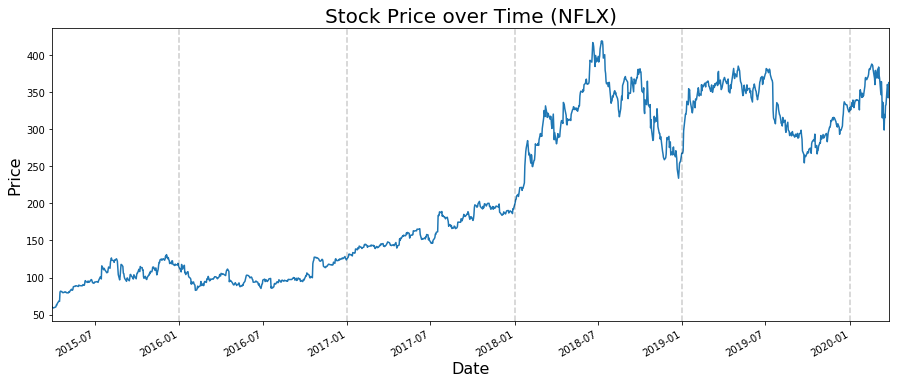

In [74]:
def plotChart(df):
    plt.figure(figsize=(15,6))
    df['Close'].plot()
    plt.title('Stock Price over Time (%s)'%tickerSymbol, fontsize=20)
    plt.xlabel('Date', fontsize=16)
    plt.ylabel('Price', fontsize=16)
    
    for year in range(2015,2021):
        plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

plotChart(df)

In [75]:
# Split dataset 80:20 train:test
# Print length of subsets
df1 = df[['Close']]

train_size = int(len(df1) * 0.8)
test_size = len(df1) - train_size

# Standarize dataset values to reduce loss
train_mean = df1[:train_size].mean()
train_std = df1[:train_size].std()

df1 = (df1-train_mean)/train_std

train, test = df1.iloc[0:train_size], df1.iloc[train_size:len(df1)]
print(len(train), len(test))

1007 252


In [9]:
# Values of training dataset now standardize
train

,Close
Date,
2015-03-30,-1.258336
2015-03-31,-1.266721
2015-04-01,-1.271812
2015-04-02,-1.270515
2015-04-06,-1.258735
...,...
2019-03-22,1.742780
2019-03-25,1.794888
2019-03-26,1.732398


In [76]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [77]:
# (samples, time_steps, features)
time_steps = 1

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.Close, time_steps)
X_test, y_test = create_dataset(test, test.Close, time_steps)

print(X_train.shape, y_train.shape)

(1006, 1, 1) (1006,)


# Building the model

In [13]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.optimizers import Adam

Using TensorFlow backend.


In [82]:
X_train.shape[-2:]

(1, 1)

In [108]:
def build_model(LSTM_unit, dropout, lr, train):
    model = Sequential()
    model.add(LSTM(units=LSTM_unit,return_sequences=True,input_shape=(train.shape[-2:])))
    model.add(Dropout(dropout))

    model.add(LSTM(units=LSTM_unit,return_sequences=True))
    model.add(Dropout(dropout))

    model.add(LSTM(units=LSTM_unit,return_sequences=True))
    model.add(Dropout(dropout))

    model.add(LSTM(units=LSTM_unit))
    model.add(Dropout(dropout))

    model.add(Dense(units=1))

    model.compile(optimizer=Adam(lr),loss='mean_squared_error')
    
    return model

model = build_model(50, 0.2, 0.001, X_train)

In [109]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_40 (LSTM)               (None, 1, 50)             10400     
_________________________________________________________________
dropout_34 (Dropout)         (None, 1, 50)             0         
_________________________________________________________________
lstm_41 (LSTM)               (None, 1, 50)             20200     
_________________________________________________________________
dropout_35 (Dropout)         (None, 1, 50)             0         
_________________________________________________________________
lstm_42 (LSTM)               (None, 1, 50)             20200     
_________________________________________________________________
dropout_36 (Dropout)         (None, 1, 50)             0         
_________________________________________________________________
lstm_43 (LSTM)               (None, 50)              

In [110]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)

Train on 905 samples, validate on 101 samples
Epoch 1/50
905/905 [==============================] - 2s 3ms/step - loss: 0.9033 - val_loss: 1.9499
Epoch 2/50
905/905 [==============================] - 0s 66us/step - loss: 0.8911 - val_loss: 1.9488
Epoch 3/50
905/905 [==============================] - 0s 66us/step - loss: 0.8859 - val_loss: 1.9370
Epoch 4/50
905/905 [==============================] - 0s 69us/step - loss: 0.8769 - val_loss: 1.9096
Epoch 5/50
905/905 [==============================] - 0s 69us/step - loss: 0.8577 - val_loss: 1.8519
Epoch 6/50
905/905 [==============================] - 0s 65us/step - loss: 0.8184 - val_loss: 1.7344
Epoch 7/50
905/905 [==============================] - 0s 62us/step - loss: 0.7467 - val_loss: 1.5135
Epoch 8/50
905/905 [==============================] - 0s 69us/step - loss: 0.6167 - val_loss: 1.1371
Epoch 9/50
905/905 [==============================] - 0s 68us/step - loss: 0.4232 - val_loss: 0.6136
Epoch 10/50
905/905 [=========================

# Evaluating the model

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

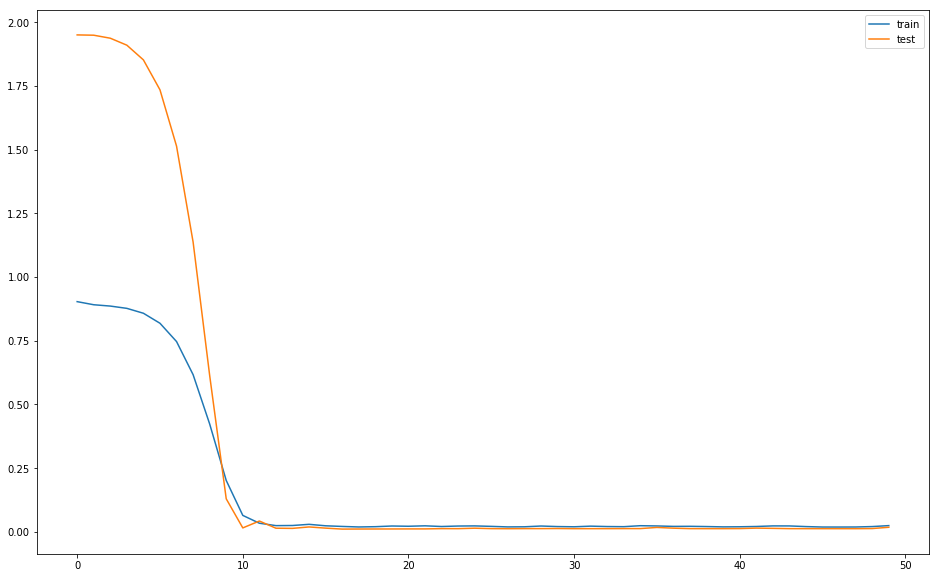

In [120]:
def loss_plot(history):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    
    return plt

loss_plot(history)

In [112]:
# Calculate original values
y_inv = (y_train*int(train_std))+int(train_mean)
ytest_inv = (y_test*int(train_std))+int(train_mean)

# Calculate predicted values
y_pred = model.predict(X_test)
ypred_inv = (y_pred*int(train_std))+int(train_mean)

In [117]:
def full_plot(y_inv, ytest_inv, ypred_inv):
    plt.plot(np.arange(0, len(y_inv)), y_inv, 'g', label="history")
    plt.plot(np.arange(len(y_inv), len(y_inv) + len(ytest_inv)), ytest_inv, marker='.', label="true")
    plt.plot(np.arange(len(y_inv), len(y_inv) + len(ytest_inv)), ypred_inv, 'r', label="prediction")
    plt.ylabel('Value')
    plt.xlabel('Time Step')
    plt.legend()
    plt.show()
    
    return plt

full_plot(y_inv, ytest_inv, ypred_inv)

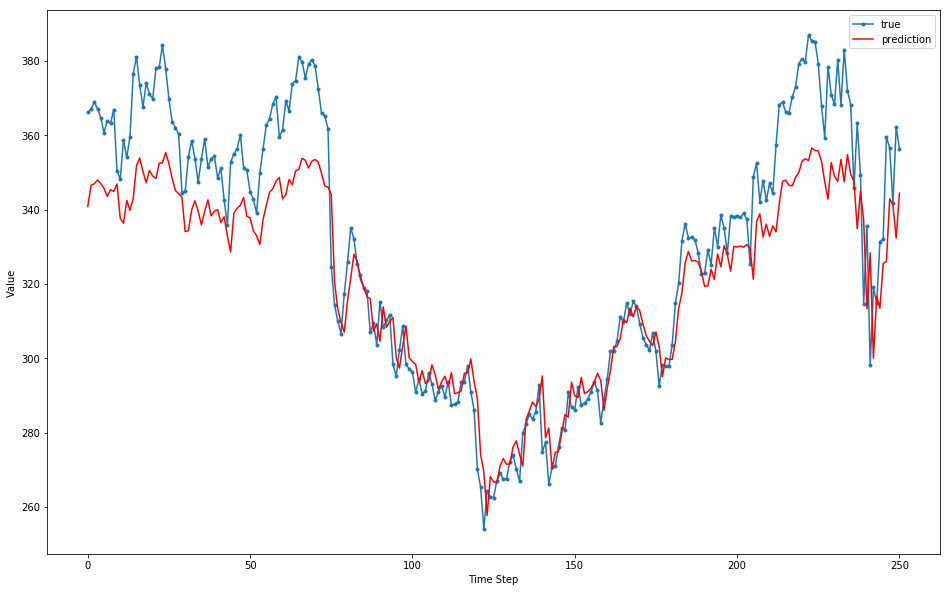

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [119]:
def compare_value_plot(y_inv, ytest_inv, ypred_inv):
    plt.plot(ytest_inv, marker='.', label="true")
    plt.plot(ypred_inv, 'r', label="prediction")
    plt.ylabel('Value')
    plt.xlabel('Time Step')
    plt.legend()
    plt.show()
    
    return plt

compare_value_plot(y_inv, ytest_inv, ypred_inv)